Predicting stock price moves with Logistic Regression 利用LR预测股票价格走势

Load Data 加载数据

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

# sys.path.insert(1, os.path.join(sys.path[0], '..'))
# from utils import MultipleTimeSeriesCV

sns.set_style('darkgrid')
idx = pd.IndexSlice

YEAR = 252

# Load Data
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

# Select Investment Universe
data = data[data.dollar_vol_rank<100]

# Create Model Data
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

Define cross-validation parameters 定义交叉验证参数

In [ ]:
# https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/utils.py
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

target = f'target_{lookahead}d'
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

Cs = np.logspace(-5, 5, 11)
cols = ['C', 'date', 'auc', 'ic', 'pval']


Run cross-validation 运行交叉验证

In [3]:
# %%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()



1e-05
	  7.3 | 010 |  -0.21% |  50.30%
	  9.3 | 020 |   2.42% |  51.99%
	 10.9 | 030 |   3.10% |  52.11%
	 13.2 | 040 |   3.49% |  52.07%
	 15.1 | 050 |   4.01% |  52.47%
	 16.5 | 060 |   3.91% |  52.25%
	 17.7 | 070 |   4.63% |  52.54%
0.0001
	  1.4 | 010 |  -0.09% |  50.42%
	  2.6 | 020 |   2.57% |  52.09%
	  4.0 | 030 |   3.32% |  52.30%
	  5.3 | 040 |   3.47% |  52.14%
	  6.7 | 050 |   3.98% |  52.52%
	  8.0 | 060 |   3.92% |  52.29%
	  9.4 | 070 |   4.70% |  52.60%
0.001
	  1.5 | 010 |   0.30% |  50.71%
	  2.8 | 020 |   2.73% |  52.15%
	  4.1 | 030 |   3.58% |  52.48%
	  5.5 | 040 |   3.21% |  52.09%
	  6.9 | 050 |   3.84% |  52.52%
	  8.2 | 060 |   3.98% |  52.33%
	  9.6 | 070 |   4.78% |  52.66%
0.01
	  1.5 | 010 |   0.51% |  50.82%
	  2.6 | 020 |   2.56% |  51.96%
	  3.9 | 030 |   3.55% |  52.35%
	  5.2 | 040 |   3.02% |  51.90%
	  6.4 | 050 |   3.88% |  52.47%
	  7.6 | 060 |   4.05% |  52.28%
	  8.8 | 070 |   4.76% |  52.58%
0.1
	  1.3 | 010 |   0.44% |  50.74%
	  2.8 | 020 | 

Evaluate Results 评估结果

In [4]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('data.h5', 'logistic/predictions')

log_scores = pd.read_hdf('data.h5', 'logistic/scores')

log_scores.info()

log_scores.groupby('C').auc.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524834,0.033162,0.462730,0.500238,0.520174,0.543183,0.608531
0.00010,75.0,0.525391,0.033182,0.465664,0.500457,0.520052,0.539332,0.617832
0.00100,75.0,0.525726,0.034815,0.442510,0.499963,0.521454,0.546595,0.637523
0.01000,75.0,0.525146,0.036003,0.447376,0.500513,0.519809,0.547387,0.633047
0.10000,75.0,0.523507,0.036001,0.439579,0.501279,0.517053,0.548712,0.617858
1.00000,75.0,0.523068,0.035935,0.438185,0.500740,0.516178,0.548256,0.614613
10.00000,75.0,0.523020,0.035928,0.438122,0.500564,0.516100,0.548231,0.614639
100.00000,75.0,0.523012,0.035928,0.438088,0.500543,0.516050,0.548237,0.614629
1000.00000,75.0,0.523011,0.035929,0.438074,0.500541,0.516038,0.548239,0.614629


Plot Validation Scores 绘制验证分数

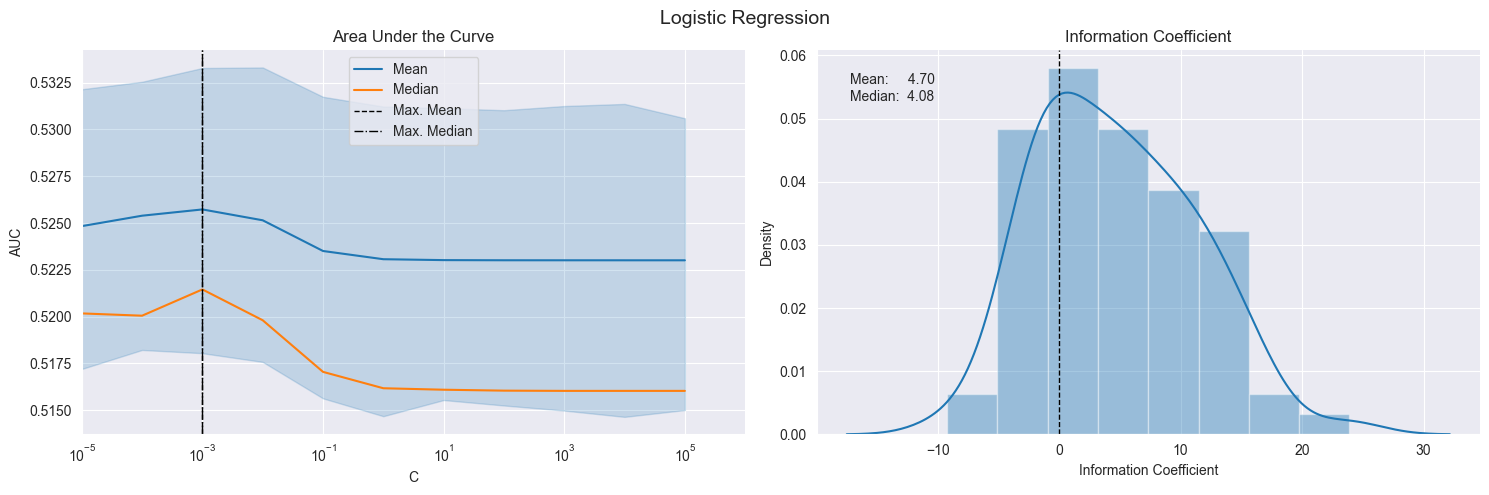

In [5]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);